In [1]:
import json
import os

hardpos_path = os.path.join('/data2/projects/VRIS/llama3', 'verb_ext_text_example_refzom.json')
with open(hardpos_path, 'r', encoding='utf-8') as f:
    hardpos_json = json.load(f)


In [3]:
print(len(hardpos_json.keys()))

from refer.refer_zom import ZREFER
refer = ZREFER('/data2/dataset/COCO2014/', 'ref-zom', 'final')


57624
loading dataset ref-zom into memory...
loading dataset split final
creating index...
index created.
DONE (t=11.10s)


In [7]:
for idx, key in enumerate(hardpos_json) :
    print(key, hardpos_json[key])
    print(refer.Refs[int(key)])
    
    if idx == 10 :
        break

2327 {'2327': []}
{'sent_ids': [2327], 'file_name': 'COCO_train2014_000000318556.jpg', 'ann_id': [], 'ref_id': 2327, 'image_id': 318556, 'split': 'train', 'source': 'zero', 'sentences': [{'tokens': ['Cooking', 'table', 'in', 'background'], 'raw': 'Cooking table in background', 'sent_id': 2327, 'sent': 'Cooking table in background'}]}
2328 {'2328': []}
{'sent_ids': [2328], 'file_name': 'COCO_train2014_000000116100.jpg', 'ann_id': [], 'ref_id': 2328, 'image_id': 116100, 'split': 'train', 'source': 'zero', 'sentences': [{'tokens': ['An', 'elephant', 'that', 'has', "it's", 'trunk', 'and', 'all', 'four', 'feet', 'in', 'the', 'water.'], 'raw': "An elephant that has it's trunk and all four feet in the water.", 'sent_id': 2328, 'sent': "An elephant that has it's trunk and all four feet in the water."}]}
2329 {'2329': ['carrying plates of pizza']}
{'sent_ids': [2329], 'file_name': 'COCO_train2014_000000538480.jpg', 'ann_id': [], 'ref_id': 2329, 'image_id': 538480, 'split': 'train', 'source': 'z

In [5]:
ref_ids = refer.getRefIds(split='train')
print(len(ref_ids))

57624


In [18]:
pos_sents = hardpos_json['9914'].values()
print(pos_sents)


dict_values([['standing next to', 'being held'], ['standing in front']])


In [19]:
from bert.tokenization_bert import BertTokenizer
import random
pos_sents = hardpos_json['9914'].values()
print(pos_sents)
pos_sents = [s for s in pos_sents if s is not None]
print(pos_sents)
pos_sent_picked = random.choice(list(pos_sents))
print(pos_sent_picked)


attention_mask = [0] * 20
padded_input_ids = [0] * 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = tokenizer.encode(text=pos_sent_picked, add_special_tokens=True)
input_ids = input_ids[:20]
print(input_ids)


dict_values([['standing next to', 'being held'], ['standing in front']])
[['standing next to', 'being held'], ['standing in front']]
['standing next to', 'being held']
[101, 100, 100, 102]


In [2]:
import datetime
import argparse
import os
import time

import torch
import torch.utils.data
from torch import nn

from functools import reduce
import operator
from bert.modeling_bert import BertModel
import torchvision
from lib import segmentation

import transforms as T
import utils
import numpy as np

import torch.nn.functional as F

import gc
from collections import OrderedDict


/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# python -m torch.distributed.launch \
# --nproc_per_node 4 \
# --master_port ${LOCALHOST} \
# train.py \
# --model lavt_one \
# --dataset refcocog \
# --splitBy umd \
# --model_id gref_umd \
# --batch-size 8 \
# --lr 0.00005 \
# --wd 1e-2 \
# --output-dir ./models/gref_umd/lavt_test_lr \
# --swin_type base \
# --pretrained_swin_weights ./pretrained_weights/swin_base_patch4_window12_384_22k.pth \
# --epochs 40 \
# --img_size 480 2>&1 | tee ./models/gref_umd/lavt_test_lr
import argparse
from utils import init_distributed_mode

def get_parser():
    parser = argparse.ArgumentParser(description="Model Training Configuration")
    parser.add_argument('--batch_size', default=8, type=int)
    parser.add_argument('--output_dir', default='./models/gref_umd/lavt_test_dset', type=str)
    parser.add_argument('--pretrained_swin_weights', default='./pretrained_weights/swin_base_patch4_window12_384_22k.pth', type=str)
    parser.add_argument('--dataset', default='refcocog', type=str)
    parser.add_argument('--splitBy', default='umd', type=str)
    parser.add_argument('--model', default='lavt_one', type=str)

    parser.add_argument('--amsgrad', action='store_true',
                        help='if true, set amsgrad to True in an Adam or AdamW optimizer.')
    parser.add_argument('-b', '--batch-size', default=8, type=int)
    parser.add_argument('--bert_tokenizer', default='bert-base-uncased', help='BERT tokenizer')
    parser.add_argument('--ck_bert', default='bert-base-uncased', help='pre-trained BERT weights')
    #parser.add_argument('--dataset', default='refcoco', help='refcoco, refcoco+, or refcocog')
    parser.add_argument('--ddp_trained_weights', action='store_true',
                        help='Only needs specified when testing,'
                             'whether the weights to be loaded are from a DDP-trained model')
    parser.add_argument('--device', default='cuda:0', help='device')  # only used when testing on a single machine
    parser.add_argument('--epochs', default=40, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--fusion_drop', default=0.0, type=float, help='dropout rate for PWAMs')
    parser.add_argument('--img_size', default=480, type=int, help='input image size')
    parser.add_argument("--local_rank", type=int, help='local rank for DistributedDataParallel')
    parser.add_argument('--lr', default=0.00005, type=float, help='the initial learning rate')
    parser.add_argument('--mha', default='', help='If specified, should be in the format of a-b-c-d, e.g., 4-4-4-4,'
                                                  'where a, b, c, and d refer to the numbers of heads in stage-1,'
                                                  'stage-2, stage-3, and stage-4 PWAMs')
    #parser.add_argument('--model', default='lavt', help='model: lavt, lavt_one')
    parser.add_argument('--model_id', default='lavt', help='name to identify the model')
    parser.add_argument('--output-dir', default='./checkpoints/', help='path where to save checkpoint weights')
    parser.add_argument('--pin_mem', action='store_true',
                        help='If true, pin memory when using the data loader.')
    parser.add_argument('--print-freq', default=10, type=int, help='print frequency')
    parser.add_argument('--refer_data_root', default='./refer/data/', help='REFER dataset root directory')
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--split', default='test', help='only used when testing')
    #parser.add_argument('--splitBy', default='unc', help='change to umd or google when the dataset is G-Ref (RefCOCOg)')
    parser.add_argument('--swin_type', default='base',
                        help='tiny, small, base, or large variants of the Swin Transformer')
    parser.add_argument('--wd', '--weight-decay', default=1e-2, type=float, metavar='W', help='weight decay',
                        dest='weight_decay')
    parser.add_argument('--window12', action='store_true',
                        help='only needs specified when testing,'
                             'when training, window size is inferred from pre-trained weights file name'
                             '(containing \'window12\'). Initialize Swin with window size 12 instead of the default 7.')
    parser.add_argument('-j', '--workers', default=8, type=int, metavar='N', help='number of data loading workers')

    parser.add_argument('--metric_learning', default=True, type=bool, help='whether to use metric learning')
    parser.add_argument('--exclude_multiobj', default=True, type=bool, help='whether to exclude multi-object images')
    parser.add_argument('--metric_mode', default='both', type=str, help='both : add hp and hn')
    parser.add_argument('--hn_prob', default=0.5, type=float, help='negative sample prob')
    
    return parser

parser = get_parser()
args = parser.parse_args([])
print('Image size: {}'.format(str(args.img_size)))

Image size: 480


In [107]:
import os
import sys
import json
import torch.utils.data as data
import torch
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import random

from bert.tokenization_bert import BertTokenizer

import h5py
from refer.refer import REFER

from args import get_parser

# Dataset configuration initialization
# parser = get_parser()
# args = parser.parse_args()


class ReferDataset(data.Dataset):

    def __init__(self,
                 args,
                 image_transforms=None,
                 target_transforms=None,
                 split='train',
                 eval_mode=False):

        self.classes = []
        self.image_transforms = image_transforms
        self.target_transform = target_transforms
        self.split = split
        self.refer = REFER(args.refer_data_root, args.dataset, args.splitBy)

        self.max_tokens = 20

        ref_ids = self.refer.getRefIds(split=self.split)
        img_ids = self.refer.getImgIds(ref_ids)

        all_imgs = self.refer.Imgs
        self.imgs = list(all_imgs[i] for i in img_ids)
        self.ref_ids = ref_ids

        self.input_ids = []
        self.attention_masks = []
        self.tokenizer = BertTokenizer.from_pretrained(args.bert_tokenizer)

        # for metric learning
        self.ROOT = '/data2/projects/seunghoon/VerbRIS/VerbCentric_CY/datasets/VRIS'
        self.metric_learning = args.metric_learning
        self.exclude_multiobj = args.exclude_multiobj
        self.metric_mode = args.metric_mode
        self.exclude_position = False

        if self.metric_learning:
            self.hardneg_prob = args.hn_prob 
            self.multi_obj_ref_ids = self._load_multi_obj_ref_ids()
            self.hardpos_meta, self.hardneg_meta = self._load_metadata()
        else:
            self.hardneg_prob = 0.0
            self.multi_obj_ref_ids = None
            self.hardpos_meta, self.hardneg_meta = None, None


        self.eval_mode = eval_mode
        # if we are testing on a dataset, test all sentences of an object;
        # o/w, we are validating during training, randomly sample one sentence for efficiency
        for r in ref_ids:
            ref = self.refer.Refs[r]

            sentences_for_ref = []
            attentions_for_ref = []

            for i, (el, sent_id) in enumerate(zip(ref['sentences'], ref['sent_ids'])):
                sentence_raw = el['raw']
                attention_mask = [0] * self.max_tokens
                padded_input_ids = [0] * self.max_tokens

                input_ids = self.tokenizer.encode(text=sentence_raw, add_special_tokens=True)

                # truncation of tokens
                input_ids = input_ids[:self.max_tokens]

                padded_input_ids[:len(input_ids)] = input_ids
                attention_mask[:len(input_ids)] = [1]*len(input_ids)

                sentences_for_ref.append(torch.tensor(padded_input_ids).unsqueeze(0))
                attentions_for_ref.append(torch.tensor(attention_mask).unsqueeze(0))

            self.input_ids.append(sentences_for_ref)
            self.attention_masks.append(attentions_for_ref)


    def _tokenize(self, sentence):
        attention_mask = [0] * self.max_tokens
        padded_input_ids = [0] * self.max_tokens

        input_ids = self.tokenizer.encode(text=sentence, add_special_tokens=True)
        # truncation of tokens
        input_ids = input_ids[:self.max_tokens]
        padded_input_ids[:len(input_ids)] = input_ids
        attention_mask[:len(input_ids)] = [1]*len(input_ids)

        return torch.tensor(padded_input_ids), torch.tensor(attention_mask)
    
    def _plot(self, img, target):
        import matplotlib.pyplot as plt

        # If img is a PyTorch tensor, convert it to a NumPy array and adjust shape
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.shape[0] == 3:  # Shape is (channels, height, width)
                img = img.transpose(1, 2, 0)  # Now shape is (height, width, channels)

        # Ensure target is a NumPy array
        if isinstance(target, torch.Tensor):
            target = target.cpu().numpy()
            if target.ndim == 3 and target.shape[0] == 1:  # Shape is (1, height, width)
                target = target.squeeze(0)  # Now shape is (height, width)

        plt.imshow(img)
        plt.imshow(target, alpha=0.5)
        plt.show()


    def _load_multi_obj_ref_ids(self):
        # Load multi-object reference IDs based on configurations
        if not self.exclude_multiobj and not self.exclude_position :
            return None
        elif self.exclude_position:
            multiobj_path = os.path.join(self.ROOT, 'multiobj_ov2_nopos.txt')
        elif self.exclude_multiobj :
            multiobj_path = os.path.join(self.ROOT, 'multiobj_ov3.txt')
        with open(multiobj_path, 'r') as f:
            return [int(line.strip()) for line in f.readlines()]

    def _load_metadata(self):
        # Load metadata for hard positive verb phrases, hard negative queries
        if 'op2' in self.metric_mode :
            hardpos_path = os.path.join(self.ROOT, 'hardpos_verbphrase_op2_1024upd.json') 
        else :
            hardpos_path = os.path.join(self.ROOT, 'hardpos_verbphrase_0906upd.json')
        # do not use hardneg_path
        hardneg_path = os.path.join(self.ROOT, 'hardneg_verb.json')

        with open(hardpos_path, 'r', encoding='utf-8') as f:
            hardpos_json = json.load(f)
        if "hardpos_only" in self.metric_mode :
            hardneg_json = None
        else :         
            with open(hardneg_path, 'r', encoding='utf-8') as q:
                hardneg_json = json.load(q)
        return hardpos_json, hardneg_json

    def get_classes(self):
        return self.classes

    def __len__(self):
        return len(self.ref_ids)

    def __getitem__(self, index):
        this_ref_id = self.ref_ids[index]
        this_img_id = self.refer.getImgIds(this_ref_id)
        this_img = self.refer.Imgs[this_img_id[0]]

        img = Image.open(os.path.join(self.refer.IMAGE_DIR, this_img['file_name'])).convert("RGB")

        ref = self.refer.loadRefs(this_ref_id)
        #print(ref)

        ref_mask = np.array(self.refer.getMask(ref[0])['mask'])
        annot = np.zeros(ref_mask.shape)
        annot[ref_mask == 1] = 1

        annot = Image.fromarray(annot.astype(np.uint8), mode="P")

        if self.image_transforms is not None:
            # resize, from PIL to tensor, and mean and std normalization
            img, target = self.image_transforms(img, annot)

        pos_sent = None
        neg_sent = None
        pos_attn_mask = None
        neg_attn_mask = None
        choice_sent = None

        if self.eval_mode:
            embedding = []
            att = []
            for s in range(len(self.input_ids[index])):
                e = self.input_ids[index][s]
                a = self.attention_masks[index][s]
                embedding.append(e.unsqueeze(-1))
                att.append(a.unsqueeze(-1))

            tensor_embeddings = torch.cat(embedding, dim=-1)
            attention_mask = torch.cat(att, dim=-1)
        else: # train phase
            choice_sent = np.random.choice(len(self.input_ids[index]))
            tensor_embeddings = self.input_ids[index][choice_sent]
            attention_mask = self.attention_masks[index][choice_sent]

            # print("object id: ", this_ref_id)
            # print("sentence ids: ", self.input_ids[index])
            # for i in range(len(self.input_ids[index])):
            #     print("object sentences: ", self.tokenizer.decode(self.input_ids[index][i].squeeze(0).tolist()))
            # # plot selected refid
            # self._plot(img, target)

            pos_sent, neg_sent = None, None
            pos_attn_mask, neg_attn_mask = None, None
            pos_mask = [[1, ]] # (GT, pos) 초기화
            neg_mask = [[0, ]] # (GT, neg) 초기화

            if self.metric_learning:
                if self.metric_mode in ['hardpos_only', 'hardpos_only_rev'] or self.hardneg_prob == 0.0:
                    pos_sent_dict = self.hardpos_meta.get(str(this_ref_id), {})
                    pos_sents = []
                    for sent_list in pos_sent_dict.values():
                        pos_sents.extend(sent_list)
                    if pos_sents:
                        pos_sent = random.choice(pos_sents)
                        pos_sent, pos_attn_mask = self._tokenize(pos_sent)
                else:
                    if random.random() < self.hardneg_prob:
                        neg_sent_dict = self.hardneg_meta.get(str(this_ref_id), {})
                        neg_sents = []
                        for sent_list in neg_sent_dict.values():
                            neg_sents.extend(sent_list)
                        if neg_sents:
                            neg_sent = random.choice(neg_sents)
                            neg_sent, neg_attn_mask = self._tokenize(neg_sent)
                    else:
                        pos_sent_dict = self.hardpos_meta.get(str(this_ref_id), {})
                        pos_sents = []
                        for sent_list in pos_sent_dict.values():
                            pos_sents.extend(sent_list)
                        if pos_sents:
                            pos_sent = random.choice(pos_sents)
                            #print("original pos sentence: ", pos_sent)
                            pos_sent, pos_attn_mask = self._tokenize(pos_sent)
                if pos_sent is None and len(self.input_ids[index]) > 1:
                    to_select = list(range(len(self.input_ids[index])))
                    to_select.remove(choice_sent)
                    choice_sent = np.random.choice(to_select)
                    pos_sent = self.input_ids[index][choice_sent]
                    pos_attn_mask = self.attention_masks[index][choice_sent]
                    #print("pos sent does not exist, use other sentence : ", self.tokenizer.decode(pos_sent.squeeze(0).tolist()))

                # concat tensors
                if img.dim() == 3:
                    img = img.unsqueeze(0)  # [1, C, H, W]
                if target.dim() == 2:
                    target = target.unsqueeze(0)  # [1, H, W]
                if tensor_embeddings.dim() == 1:
                    tensor_embeddings = tensor_embeddings.unsqueeze(0)  # [1, max_tokens]
                if attention_mask.dim() == 1:
                    attention_mask = attention_mask.unsqueeze(0)  # [1, max_tokens]
                if pos_sent is not None and pos_sent.dim() == 1:
                    pos_sent = pos_sent.unsqueeze(0)
                if neg_sent is not None and neg_sent.dim() == 1:
                    neg_sent = neg_sent.unsqueeze(0)
                if pos_attn_mask is not None and pos_attn_mask.dim() == 1:
                    pos_attn_mask = pos_attn_mask.unsqueeze(0)
                if neg_attn_mask is not None and neg_attn_mask.dim() == 1:
                    neg_attn_mask = neg_attn_mask.unsqueeze(0)


            # print("index: ", self.input_ids[index])
            # print("choice_sent: ", choice_sent)
            # print("tensor_embeddings: ", tensor_embeddings)
            # print("original sentence: ", self.tokenizer.decode(tensor_embeddings.squeeze(0).tolist()))
            # print("pos_sent: ", pos_sent)
            # print("neg_sent: ", neg_sent)
            # print("pos_attn_mask: ", pos_attn_mask)
            # print("neg_attn_mask: ", neg_attn_mask)
            # print(img.shape, target.shape, tensor_embeddings.shape, attention_mask.shape, pos_mask, neg_mask)

            if (pos_sent is not None) and (neg_sent is not None):
                img = torch.stack([img, img, img], dim=0)
                target = torch.stack([target, target, target], dim=0)
                tensor_embeddings = torch.stack([tensor_embeddings, pos_sent, neg_sent], dim=0)
                attention_mask = torch.stack([attention_mask, pos_attn_mask, neg_attn_mask], dim=0)
                pos_mask = [[1, 1, 0]]
                neg_mask = [[0, 0, 1]]
            elif (pos_sent is not None and not neg_sent) or (neg_sent is not None and not pos_sent):
                img = torch.stack([img, img], dim=0)
                target = torch.stack([target, target], dim=0)
                tensor_embeddings = torch.stack([tensor_embeddings, pos_sent], dim=0) if (pos_sent is not None) \
                                    else torch.stack([tensor_embeddings, neg_sent], dim=0)
                attention_mask = torch.stack([attention_mask, pos_attn_mask], dim=0) if (pos_attn_mask is not None) \
                                    else torch.stack([attention_mask, neg_attn_mask], dim=0)
                pos_mask = [[1, int(pos_sent is not None)]]
                neg_mask = [[0, int(neg_sent is not None)]]
            else:
                pass
        return img, target, tensor_embeddings, attention_mask, pos_mask, neg_mask


In [108]:
def get_dataset(image_set, transform, args):
    #from data.dataset_refer_bert import ReferDataset
    ds = ReferDataset(args,
                      split=image_set,
                      image_transforms=transform,
                      target_transforms=None
                      )
    num_classes = 2

    return ds, num_classes

def get_transform(args):
    transforms = [T.Resize(args.img_size, args.img_size),
                  T.ToTensor(),
                  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ]

    return T.Compose(transforms)


def criterion(input, target):
    weight = torch.FloatTensor([0.9, 1.1]).cuda()
    return nn.functional.cross_entropy(input, target, weight=weight)

In [ ]:
dataset, num_classes = get_dataset("train",
                                    get_transform(args=args),
                                    args=args)
train_sampler = torch.utils.data.distributed.DistributedSampler(dataset, num_replicas=1, rank=0,
                                                                    shuffle=True)


loading dataset refcocog into memory...
Split by umd!
creating index...
index created.
DONE (t=6.64s)


In [118]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate(batch):
    imgs, targets, tensor_embeddings, attention_masks, pos_masks, neg_masks = zip(*batch)
    imgs = torch.cat([img for img in imgs], dim=0)
    targets = torch.cat([tgt for tgt in targets], dim=0)
    
    tensor_embeddings = torch.cat([t_e for t_e in tensor_embeddings], dim=0)
    attention_masks = torch.cat([a_m for a_m in attention_masks], dim=0)

    # Handle pos_masks
    if any(pos_mask is not None for pos_mask in pos_masks):
        pos_masks = [mask if mask is not None else torch.zeros_like(tensor_embeddings[0]) for mask in pos_masks]
        pos_masks = pad_sequence(pos_masks, batch_first=True, padding_value=0)
    else:
        pos_masks = None

    # Handle neg_masks
    if any(neg_mask is not None for neg_mask in neg_masks):
        neg_masks = [mask if mask is not None else torch.zeros_like(tensor_embeddings[0]) for mask in neg_masks]
        neg_masks = pad_sequence(neg_masks, batch_first=True, padding_value=0)
    else:
        neg_masks = None

    return imgs, targets, tensor_embeddings, attention_masks, pos_masks, neg_masks


data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size,
        sampler=train_sampler, num_workers=args.workers, 
        collate_fn=custom_collate,  pin_memory=args.pin_mem, drop_last=True)

# single sample from dataloader
img, target, tensor_embeddings, attention_mask, pos_mask, neg_mask = next(iter(data_loader))

print(img.shape, target.shape, tensor_embeddings.shape, attention_mask.shape, pos_mask, neg_mask)

/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use Inter

torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([3, 1, 20])



torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([3, 1, 20])torch.Size([2, 1, 20])




torch.Size([1, 20])torch.Size([3, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])



torch.Size([3, 1, 20])
torch.Size([2, 1, 20])torch.Size([1, 20])torch.Size([2, 1, 20])torch.Size([1, 20])
torch.Size([2, 1, 20])



torch.Size([2, 1, 20])torch.Size([2, 1, 20])
torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([3, 1, 20])torch.Size([1, 20])

torch.Size([3, 1, 20])



torch.Size([2, 1, 20])
torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])
torch.Size([2, 1, 20])



torch.Size([2, 1, 20])torch.Size([3, 1, 20])
torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])torch.Size([2, 1, 20])

torch.Size([2, 1, 20])


torch.Size([2, 1, 20])
to

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/tmp/ipykernel_2235050/518736739.py", line 10, in custom_collate
    tensor_embeddings = torch.cat(*tensor_embeddings, dim=0)
TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)



torch.Size([2, 1, 20])
torch.Size([3, 1, 20])torch.Size([2, 1, 20])
torch.Size([2, 1, 20])

torch.Size([2, 1, 20])torch.Size([3, 1, 20])

torch.Size([2, 1, 20])torch.Size([3, 1, 20])

torch.Size([3, 1, 20])torch.Size([3, 1, 20])

torch.Size([2, 1, 20])torch.Size([2, 1, 20])

torch.Size([2, 1, 20])torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([3, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([3, 1, 20])

torch.Size([3, 1, 20])torch.Size([2, 1, 20])

torch.Size([2, 1, 20])torch.Size([2, 1, 20])

torch.Size([2, 1, 20])torch.Size([2, 1, 20])

torch.Size([3, 1, 20])torch.Size([3, 1, 20])

torch.Size([2, 1, 20])torch.Size([2, 1, 20])

torch.Size([2, 1, 20])torch.Size([2, 1, 20])

torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([3, 1, 20])
torch.Size([3, 1, 20])
torch.Size([3, 1, 20])
torch.Size([3, 1, 20])
torch.Size([1, 20])
torch.Size([3,

In [4]:
# sample datas
for i, (img, target, tensor_embeddings, attention_mask) in enumerate(data_loader):
    print(img.shape)
    print(target.shape)
    print(tensor_embeddings.shape)
    print(attention_mask.shape)
    print(attention_mask[0])
    break

[{'image_id': 391435, 'split': 'train', 'sentences': [{'tokens': ['the', 'reflection', 'of', 'the', 'man', 'shaving'], 'raw': 'the reflection of the man shaving', 'sent_id': 13437, 'sent': 'the reflection of the man shaving'}, {'tokens': ['image', 'of', 'a', 'man', 'shaving', 'on', 'a', 'laptop', 'screen'], 'raw': 'image of a man shaving on a laptop screen', 'sent_id': 13438, 'sent': 'image of a man shaving on a laptop screen'}], 'file_name': 'COCO_train2014_000000391435_1709050.jpg', 'category_id': 1, 'ann_id': 1709050, 'sent_ids': [13437, 13438], 'ref_id': 45871}][{'image_id': 421848, 'split': 'train', 'sentences': [{'tokens': ['the', 'tallest', 'giraffe', 'among', 'the', 'two'], 'raw': 'The tallest giraffe among the two', 'sent_id': 82708, 'sent': 'the tallest giraffe among the two'}, {'tokens': ['the', 'tallest', 'of', 'two', 'giraffes'], 'raw': 'The tallest of two giraffes.', 'sent_id': 82709, 'sent': 'the tallest of two giraffes'}], 'file_name': 'COCO_train2014_000000421848_59647

/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/seunghoon/.conda/envs/lavt/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use Inter

[{'image_id': 263823, 'split': 'train', 'sentences': [{'tokens': ['the', 'umpire', 'behind', 'the', 'plate'], 'raw': 'the umpire behind the plate', 'sent_id': 9335, 'sent': 'the umpire behind the plate'}, {'tokens': ['umpire', 'wearing', 'blue'], 'raw': 'umpire wearing blue', 'sent_id': 9336, 'sent': 'umpire wearing blue'}], 'file_name': 'COCO_train2014_000000263823_2160611.jpg', 'category_id': 1, 'ann_id': 2160611, 'sent_ids': [9335, 9336], 'ref_id': 8614}]
[{'image_id': 170366, 'split': 'train', 'sentences': [{'tokens': ['the', 'boy', 'in', 'the', 'suit'], 'raw': 'The boy in the suit.', 'sent_id': 96474, 'sent': 'the boy in the suit'}, {'tokens': ['a', 'young', 'man', 'with', 'brown', 'hair', 'in', 'a', 'black', 'suit', ',', 'with', 'a', 'black', 'hat', 'with', 'sunglasses', 'resting', 'on', 'it'], 'raw': 'A young man with brown hair in a black suit, with a black hat with sunglasses resting on it', 'sent_id': 96475, 'sent': 'a young man with brown hair in a black suit , with a black 

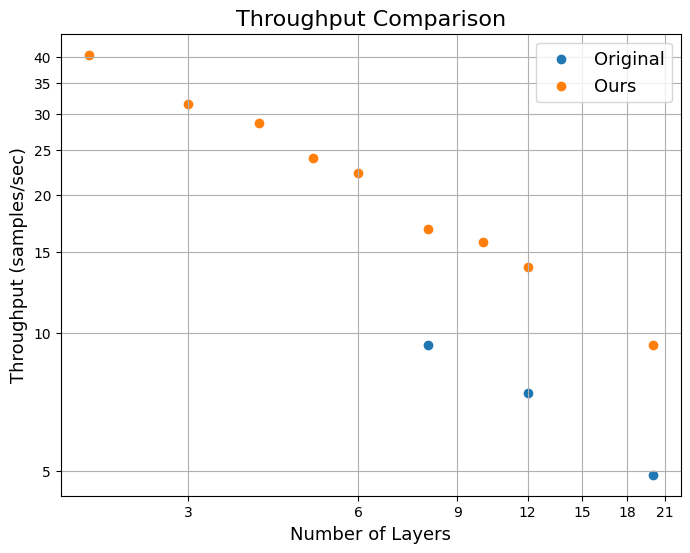

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# Data from the table
models = ['eqV2-S', 'eqV2-M', 'eqV2-L'] 
layers = [2, 4, 8, 3, 6, 12, 5, 10, 20]
original_layers = [8, 12, 20]
original_throughput = [9.4, 7.4, 4.9]
ours_throughput = [40.4, 28.7, 16.8, 31.6, 22.3, 13.9, 24.1, 15.8, 9.4]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(original_layers, original_throughput, label='Original')
ax.scatter(layers, ours_throughput, label='Ours')
ax.set_xscale('log', base=2)
ax.set_yscale('log',base=2)
ax.set_title('Throughput Comparison', fontsize=16)
ax.set_xlabel('Number of Layers', fontsize=13)
ax.set_ylabel('Throughput (samples/sec)', fontsize=13)
ax.legend(fontsize=12)

# Set the tick locator and formatter to show integer values
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.grid(True)

plt.show()